## model: godzina - dzien tygodnia

### getting demand data

In [1]:
import pandas as pd
from datetime import date
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

weather_start_year = 2014
end_dt = '2019-03-31'
# 2 months:
# start_dt = '2019-02-01'

#6 months:
# start_dt = '2018-10-01'

# 12 months:
# start_dt = '2018-04-01'

# #24 months:
# start_dt = '2017-04-01'

# # #60 months:
start_dt = '2014-04-01'

weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = datetime.timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start_dt, end_dt)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,Krajowe zapotrzebowanie na moc,DataGodz
DataGodz,,
2014-04-01 01:00:00,15820.063,2014-04-01 01:00:00
2014-04-01 02:00:00,15253.238,2014-04-01 02:00:00
2014-04-01 03:00:00,14943.475,2014-04-01 03:00:00
2014-04-01 04:00:00,14880.913,2014-04-01 04:00:00
2014-04-01 05:00:00,15148.463,2014-04-01 05:00:00
...,...,...
2019-03-31 20:00:00,18097.938,2019-03-31 20:00:00
2019-03-31 21:00:00,18774.000,2019-03-31 21:00:00
2019-03-31 22:00:00,17979.813,2019-03-31 22:00:00


In [2]:
dataAll
#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz','weekDay']] 
# modelData2.set_index('DataGodz')
# modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
def create_model(dane, sezon, maxiter = 20, regresor = None):
    start = datetime.datetime.now()

    #auto ARIMA
    m = auto_arima(dane, 
           seasonal = True, 
           m=sezon, 
           maxiter = maxiter,
           trace = True,
           exogenous = regresor)#.summary()
    print('autoARIMA time: ' + str(datetime.datetime.now() - start))
    order = m.get_params()['order']
    seasonal_order = m.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    fit_start =  datetime.datetime.now()
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse',exog = regresor)
    model_fit = model.fit() 
    
    print('fit time = ' + str(datetime.datetime.now() - fit_start))
    return model_fit

### Getting weather data

In [4]:
weather_cols = [
'Kod stacji'
,'Nazwa stacji'
,'Rok' 
,'Miesiąc' 
,'Dzień'
,'Godzina' 
,'Wysokość podstawy chmur CL CM szyfrowana [kod]'
,'Status pomiaru HPOD' 
,'Wysokość podstawy niższej  [m]'
,'Status pomiaru HPON' 
,'Wysokość podstawy wyższej [m]'
,'Status pomiaru HPOW' 
,'Wysokość podstawy tekstowy [opis]' 
,'Pomiar przyrzadem 1 (niższa) [P]'
,'Pomiar przyrzadem 2 (wyższa) [P]'
,'Widzialność  [kod]' 
,'Satus pomiaru WID' 
,'Widzialność operatora [m]' 
,'Status pomiaru WIDO' 
,'Widzialność automat [m]'
,'Status pomiaru WIDA' 
,'Zachmurzenie ogólne [oktanty]'
,'Status pomiaru NOG'  
,'Kierunek wiatru  [°]'
,'Status pomiaru KRWR' 
,'Prędkość wiatru  [m/s]' ######################################
,'Status pomiaru FWR'  
,'Poryw wiatru  [m/s]' 
,'Status pomiaru PORW' 
,'Temperatura powietrza [°C]' ######################################
,'Status pomiaru TEMP' 
,'Temperatura termometru zwilżonego [°C]'
,'Status pomiaru TTZW' 
,'Wskaźnik wentylacji [W/N]' 
,'Wskaźnik lodu [L/W]' 
,'Ciśnienie pary wodnej [hPa]'  
,'Status pomiaru CPW'  
,'Wilgotność względna [%]'
,'Status pomiaru WLGW' 
,'Temperatura punktu rosy [°C]' 
,'Status pomiaru TPTR' 
,'Ciśnienie na pozimie stacji [hPa]'  
,'Status pomiaru PPPS' 
,'Ciśnienie na pozimie morza [hPa]'
,'Status pomiaru PPPM' 
,'Charakterystyka tendencji [kod]' 
,'Wartość tendencji [wartość]'  
,'Status pomiaru APP'  
,'Opad za 6 godzin [mm]'  
,'Status pomiaru WO6G'
,'Rodzaj opadu za 6 godzin [kod]'
,'Status pomiaru ROPT'
,'Pogoda bieżąca [kod]'
,'Pogoda ubiegła [kod]'
,'Zachmurzenie niskie [oktanty]'
,'Status pomiaru CLCM'
,'Chmury CL [kod]'
,'Status pomiaru CHCL'
,'Chmury CL tekstem'
,'Chmury CM [kod]'
,'Status pomiaru CHCM'
,'Chmury CM tekstem'
,'Chmury CH [kod]'
,'Status pomiaru CHCH'
,'Chmury CH tekstem'
,'Stan gruntu [kod]'
,'Status pomiaru SGRN'
,'Niedosyt wilgotności [hPa}'
,'Status pomiaru DEFI'
,'Usłonecznienie'
,'Status pomiaru USLN'
,'Wystąpienie rosy [0/1]'
,'Status pomiaru ROSW'
,'Poryw maksymalny za okres WW [m/s]'
,'Status pomiaru PORK'
,'Godzina wystąpienia porywu'
,'Minuta wystąpienia porywu'
,'Temperatura gruntu -5 [°C]'
,'Status pomiaru TG05'
,'Temperatura gruntu -10 [°C]'
,'Status pomiaru TG10'
,'Temperatura gruntu -20 [°C]'
,'Status pomiaru TG20'
,'Temperatura gruntu -50 [°C]'
,'Status pomiaru TG50'
,'Temperatura gruntu -100 [°C]'
,'Status pomiaru TG100'
,'Temperatura minimalna za 12 godzin  [°C]'
,'Status pomiaru TMIN'
,'Temperatura maksymalna za 12 godzin [°C]'
,'Status pomiaru TMAX'
,'Temperatura minimalna przy gruncie za 12 godzin [°C]'
,'Status pomiaru TGMI'
,'Równoważnik wodny śniegu [mm/cm]'
,'Status pomiaru RWSN'
,'Wysokość pokrywy śnieżnej [cm]'
,'Status pomiaru PKSN'
,'Wysokość świeżo spadłego śniegu  [cm]'
,'Status pomiaru HSS'
,'Wysokość śniegu na poletku [cm]'
,'Status pomiaru GRSN'
,'Gatunek śniegu  [kod]'
,'Ukształtowanie pokrywy [kod]'
,'Wysokość próbki [cm]'
,'Status pomiaru HPRO'
,'Ciężar próbki [g]'
,'Status pomiaru CIPR'
]

In [5]:
def readWeatherFile(file_name):
    file = '../../Additional Data/Weather/' + file_name
    df = pd.read_csv(filepath_or_buffer = file
                     ,engine='python'
                     ,sep = ','
                     ,header = None
                    )

    df.columns = weather_cols
    return df
# test:
# readWeatherFile('s_t_690_2017.csv')

In [6]:
# getting list of s_d_t .csv files

import glob
file_names_list = (glob.glob("..\\..\\Additional Data\\Weather\\s_t_*.csv"))
lst=[]

for file_name in file_names_list:
    file_name = file_name[-16:]
    file_name = file_name.replace("\\","")
    lst.append(file_name)
#     print(file_name)
file_names_list = lst
lst=[]

In [7]:
names_to_drop=[]
for i in file_names_list:
    if(int(i[-8:-4]) < weather_start_year):
        names_to_drop.append(i)
for i in names_to_drop:
    file_names_list.remove(i)
file_names_list

['s_t_01_2020.csv',
 's_t_02_2020.csv',
 's_t_03_2020.csv',
 's_t_04_2020.csv',
 's_t_05_2020.csv',
 's_t_06_2020.csv',
 's_t_07_2020.csv',
 's_t_08_2020.csv',
 's_t_09_2020.csv',
 's_t_100_2014.csv',
 's_t_100_2015.csv',
 's_t_100_2016.csv',
 's_t_100_2017.csv',
 's_t_100_2018.csv',
 's_t_100_2019.csv',
 's_t_100_2020.csv',
 's_t_105_2014.csv',
 's_t_105_2015.csv',
 's_t_105_2016.csv',
 's_t_105_2017.csv',
 's_t_105_2018.csv',
 's_t_105_2019.csv',
 's_t_105_2020.csv',
 's_t_10_2020.csv',
 's_t_115_2014.csv',
 's_t_115_2015.csv',
 's_t_115_2016.csv',
 's_t_115_2017.csv',
 's_t_115_2018.csv',
 's_t_115_2019.csv',
 's_t_115_2020.csv',
 's_t_120_2014.csv',
 's_t_120_2015.csv',
 's_t_120_2016.csv',
 's_t_120_2017.csv',
 's_t_120_2018.csv',
 's_t_120_2019.csv',
 's_t_120_2020.csv',
 's_t_125_2014.csv',
 's_t_125_2015.csv',
 's_t_125_2016.csv',
 's_t_125_2017.csv',
 's_t_125_2018.csv',
 's_t_125_2019.csv',
 's_t_125_2020.csv',
 's_t_135_2014.csv',
 's_t_135_2015.csv',
 's_t_135_2016.csv',
 '

In [8]:
weatherDF = readWeatherFile(file_names_list[1]).iloc[0:0] #dummy
weatherDF = weatherDF[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
for file_name in file_names_list:
    weatherDF = weatherDF.append(
        readWeatherFile(file_name)[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
        ,ignore_index=True
        )
    print(file_name)
weatherDF.isna().sum()

s_t_01_2020.csv
s_t_02_2020.csv
s_t_03_2020.csv
s_t_04_2020.csv
s_t_05_2020.csv
s_t_06_2020.csv
s_t_07_2020.csv
s_t_08_2020.csv
s_t_09_2020.csv
s_t_100_2014.csv
s_t_100_2015.csv
s_t_100_2016.csv
s_t_100_2017.csv
s_t_100_2018.csv
s_t_100_2019.csv
s_t_100_2020.csv
s_t_105_2014.csv
s_t_105_2015.csv
s_t_105_2016.csv
s_t_105_2017.csv
s_t_105_2018.csv
s_t_105_2019.csv
s_t_105_2020.csv
s_t_10_2020.csv
s_t_115_2014.csv
s_t_115_2015.csv
s_t_115_2016.csv
s_t_115_2017.csv
s_t_115_2018.csv
s_t_115_2019.csv
s_t_115_2020.csv
s_t_120_2014.csv
s_t_120_2015.csv
s_t_120_2016.csv
s_t_120_2017.csv
s_t_120_2018.csv
s_t_120_2019.csv
s_t_120_2020.csv
s_t_125_2014.csv
s_t_125_2015.csv
s_t_125_2016.csv
s_t_125_2017.csv
s_t_125_2018.csv
s_t_125_2019.csv
s_t_125_2020.csv
s_t_135_2014.csv
s_t_135_2015.csv
s_t_135_2016.csv
s_t_135_2017.csv
s_t_135_2018.csv
s_t_135_2019.csv
s_t_135_2020.csv
s_t_155_2014.csv
s_t_155_2015.csv
s_t_155_2016.csv
s_t_155_2017.csv
s_t_155_2018.csv
s_t_155_2019.csv
s_t_155_2020.csv
s_t_160

Nazwa stacji                  0
Rok                           0
Miesiąc                       0
Dzień                         0
Godzina                       0
Prędkość wiatru  [m/s]        0
Temperatura powietrza [°C]    0
dtype: int64

In [9]:
weatherDF['Nazwa stacji'].unique()

array(['BIELSKO-BIAŁA', 'ZAKOPANE', 'KASPROWY WIERCH', 'HALA GĄSIENICOWA',
       'NOWY SĄCZ', 'KROSNO', 'LESKO', 'JELENIA GÓRA', 'ŚNIEŻKA',
       'KŁODZKO', 'OPOLE', 'RACIBÓRZ', 'CZĘSTOCHOWA',
       'KATOWICE-MUCHOWIEC', 'KRAKÓW-BALICE', 'KIELCE-SUKÓW', 'TARNÓW',
       'SANDOMIERZ', 'RZESZÓW-JASIONKA', 'ZAMOŚĆ', 'ZIELONA GÓRA',
       'LEGNICA', 'LESZNO', 'WROCŁAW-STRACHOWICE', 'KALISZ', 'WIELUŃ',
       'ŁÓDŹ-LUBLINEK', 'SULEJÓW', 'KOZIENICE', 'LUBLIN-RADAWIEC',
       'WŁODAWA', 'SŁUBICE', 'GORZÓW WIELKOPOLSKI', 'POZNAŃ-ŁAWICA',
       'KOŁO', 'PŁOCK', 'WARSZAWA-OKĘCIE', 'SIEDLCE', 'TERESPOL',
       'ŚWINOUJŚCIE', 'SZCZECIN', 'RESKO-SMÓLSKO', 'PIŁA', 'CHOJNICE',
       'TORUŃ', 'MŁAWA', 'OLSZTYN', 'MIKOŁAJKI', 'BIAŁYSTOK',
       'KOŁOBRZEG-DŹWIRZYNO', 'KOSZALIN', 'USTKA', 'ŁEBA', 'LĘBORK',
       'HEL', 'GDAŃSK-ŚWIBNO', 'ELBLĄG-MILEJEWO', 'KĘTRZYN', 'SUWAŁKI',
       'KOŁOBRZEG', 'POZNAŃ', 'WARSZAWA', 'WROCŁAW', 'ŁÓDŹ', 'KATOWICE'],
      dtype=object)

In [10]:
#wybranie top6 zaludnionych
# weatherDF = weatherDF[weatherDF['Nazwa stacji'].isin(
# ['WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
# ])]

In [11]:
#wywalenie odstających
weatherDF = weatherDF[~weatherDF['Nazwa stacji'].isin(
[
#     'WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
    'KASPROWY WIERCH',
    'ŚNIEŻKA',
    'ZAKOPANE'
])]

In [12]:
weatherByStation = weatherDF[
            ['Nazwa stacji',
           'Prędkość wiatru  [m/s]',
           'Temperatura powietrza [°C]']
         ].groupby('Nazwa stacji').mean()

<AxesSubplot:xlabel='Nazwa stacji'>

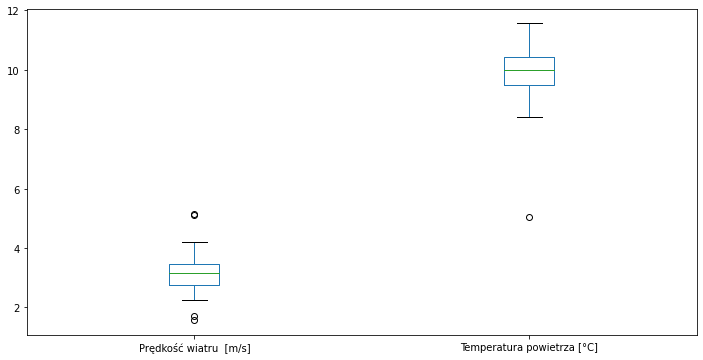

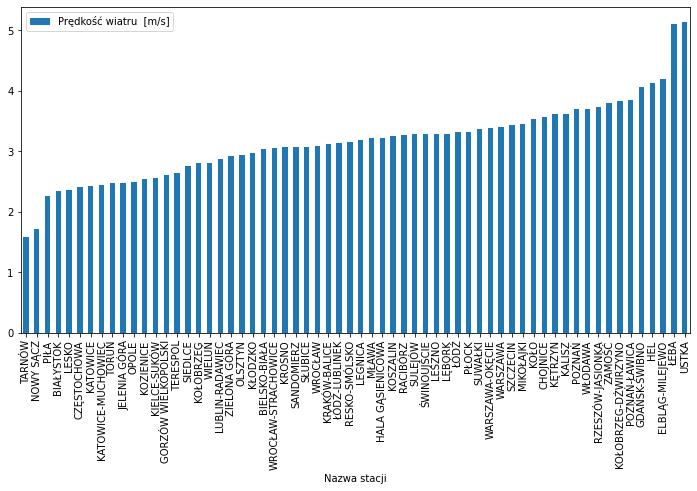

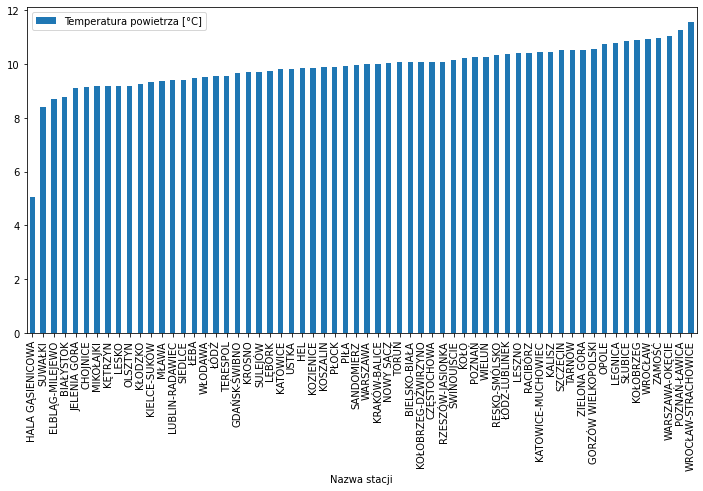

In [13]:
weatherByStation.plot(kind='box', figsize=(12,6))
weatherByStation = weatherByStation.sort_values('Prędkość wiatru  [m/s]')
weatherByStation[['Prędkość wiatru  [m/s]']].plot(kind='bar', figsize=(12,6))
weatherByStation = weatherByStation.sort_values('Temperatura powietrza [°C]')
weatherByStation[['Temperatura powietrza [°C]']].plot(kind='bar', figsize=(12,6))
# weatherByStation


In [14]:
def date_from_row(x):
    y=x['Rok']
    m=x['Miesiąc']
    d=x['Dzień']
    return date(y,m,d)

In [15]:
weatherDF['DataGodz'] = weatherDF.apply(lambda x: date_from_row(x), axis = 1)
weatherDF['DataGodz'] = pd.to_datetime(weatherDF['DataGodz']) 

weatherDF['DataGodz'] = weatherDF['DataGodz'] + weatherDF['Godzina'].apply(
   lambda x: relativedelta(hours=x)
)

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [16]:
weatherAvg = weatherDF[
            ['Nazwa stacji',
           'Temperatura powietrza [°C]',
            'DataGodz']
         ].groupby('DataGodz',as_index=False).mean()

In [17]:
weatherAvg

,DataGodz,Temperatura powietrza [°C]
0,2014-01-01 00:00:00,0.321569
1,2014-01-01 01:00:00,0.252941
2,2014-01-01 02:00:00,0.282353
3,2014-01-01 03:00:00,0.345098
4,2014-01-01 04:00:00,0.435294
...,...,...
61363,2020-12-31 19:00:00,-0.229630
61364,2020-12-31 20:00:00,-0.379630
61365,2020-12-31 21:00:00,-0.511111
61366,2020-12-31 22:00:00,-0.666667


#### łączenie pogody z zapotrzebowaniem

In [18]:
dataAll = pd.merge(dataAll, weatherAvg, how='left',on='DataGodz')

#### petla godzinowa

In [19]:
models_num = 24*7 #168
my_models = [None] * models_num

In [20]:
# modelData2.where(modelData2['DataGodz'].hour==2)
# modelData2[dataAll['Godzina']==23]['Krajowe zapotrzebowanie na moc']
# dataAll.loc[(dataAll['Godzina']==24) & (dataAll['weekDayNum']==0)]#['Krajowe zapotrzebowanie na moc']

In [23]:
starttime = datetime.datetime.now()
print('start petli: ' +str(starttime))
for i in range(models_num):
    print('##### startuje dopasowanie modelu dla godziny: ' + str(i))
    my_models[i] = create_model(
        dataAll.loc[(dataAll['Godzina'] %24 ==i % 24) & 
                    (dataAll['weekDayNum']==int(i/24))]
        ['Krajowe zapotrzebowanie na moc']
        ,1
        ,regresor = dataAll.loc[(dataAll['Godzina'] %24 ==i % 24) & 
                    (dataAll['weekDayNum']==int(i/24))]
        [['Temperatura powietrza [°C]']]
    )
    print('##### Koniec dopasowania modelu dla godziny: ' + str(i))
    print('#####')
print('czas trwania calosci: ' +str(datetime.datetime.now()-starttime))

start petli: 2021-05-23 08:56:52.150866
##### startuje dopasowanie modelu dla godziny: 0
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4333.038, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4412.222, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4381.156, Time=0.16 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4339.767, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4410.233, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4330.879, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4328.383, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4330.160, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4328.631, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4333.052, Time=0.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4328.219, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4338.397, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4330.430, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4330.377, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4329.246, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4332.261, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.731 seconds
autoARIMA time: 0:00:03.738419
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.232713
##### Koniec dopasowania modelu dla godziny: 0
#####
##### startuje dopasowanie modelu dla godziny: 1
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4052.309, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4122.396, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4086.955, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4053.203, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4120.407, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4050.153, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4052.141, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4052.717, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4052.563, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4052.290, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4053.187, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4055.737, Time=0.42 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4048.742, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4050.629, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4051.284, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4051.165, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4051.415, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4051.637, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4050.653, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4051.647, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4051.890, Time=0.38 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.795 seconds
autoARIMA time: 0:00:04.804087
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.249074
##### Koniec dopasowania modelu dla godziny: 1
#####
##### startuje dopasowanie modelu dla godziny: 2
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4063.030, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4134.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4102.316, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4065.656, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4132.222, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4060.693, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4062.428, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4063.434, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4062.989, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4062.593, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4063.716, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4066.123, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4059.027, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4061.055, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4062.186, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4061.309, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4061.527, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4064.138, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4061.018, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4062.281, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4063.136, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.620 seconds
autoARIMA time: 0:00:04.628095
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.225553
##### Koniec dopasowania modelu dla godziny: 2
#####
##### startuje dopasowanie modelu dla godziny: 3
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4076.241, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4147.680, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4115.556, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4078.844, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4145.687, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4074.258, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4074.896, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4075.834, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4076.922, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4075.889, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4076.911, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4079.486, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4072.396, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4073.633, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4074.680, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4075.100, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4075.416, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4077.336, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4074.406, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4075.546, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4076.292, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.230 seconds
autoARIMA time: 0:00:04.229597
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.202567
##### Koniec dopasowania modelu dla godziny: 3
#####
##### startuje dopasowanie modelu dla godziny: 4
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4105.042, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4177.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4146.171, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4107.618, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4175.557, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4102.215, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4101.954, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4103.406, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4103.011, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4105.380, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4100.889, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4106.254, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4100.371, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4102.094, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4103.828, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4104.155, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4102.096, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4103.222, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4104.625, Time=0.27 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 3.608 seconds
autoARIMA time: 0:00:03.615208
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.165594
##### Koniec dopasowania modelu dla godziny: 4
#####
##### startuje dopasowanie modelu dla godziny: 5
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4153.032, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4225.251, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4194.725, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4154.065, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4223.263, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4151.395, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4148.624, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4149.938, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4149.805, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4154.335, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4147.513, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4152.788, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4148.465, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4148.536, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4148.881, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4151.876, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.974 seconds
autoARIMA time: 0:00:02.979637
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.124797
##### Koniec dopasowania modelu dla godziny: 5
#####
##### startuje dopasowanie modelu dla godziny: 6
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4268.614, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4334.823, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4302.759, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4265.469, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4332.827, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4262.238, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4263.386, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4265.101, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4261.457, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4262.930, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4268.557, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4260.172, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4264.079, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4263.582, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4261.505, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4261.072, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4266.649, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.163 seconds
autoARIMA time: 0:00:03.162611
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.137615
##### Koniec dopasowania modelu dla godziny: 6
#####
##### startuje dopasowanie modelu dla godziny: 7
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4536.812, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4615.192, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4579.269, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4533.536, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4613.196, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4526.526, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4530.314, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4533.032, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4527.339, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4555.212, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4526.655, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.848 seconds
autoARIMA time: 0:00:01.847770
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.351583
##### Koniec dopasowania modelu dla godziny: 7
#####
##### startuje dopasowanie modelu dla godziny: 8
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4650.292, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4745.084, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4706.545, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4645.827, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4743.090, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4639.627, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4642.154, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4643.081, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4680.119, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4641.212, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.947 seconds
autoARIMA time: 0:00:01.950737
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.315593
##### Koniec dopasowania modelu dla godziny: 8
#####
##### startuje dopasowanie modelu dla godziny: 9
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4676.367, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4770.664, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4732.764, Time=0.16 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4768.726, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4669.608, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4664.598, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4671.865, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4676.433, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4667.973, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.106 seconds
autoARIMA time: 0:00:02.106339
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.265041
##### Koniec dopasowania modelu dla godziny: 9
#####
##### startuje dopasowanie modelu dla godziny: 10
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4658.112, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4747.591, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4710.088, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4659.200, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4745.593, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4653.045, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4649.799, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4654.814, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4683.164, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4651.180, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.840 seconds
autoARIMA time: 0:00:01.843215
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.275078
##### Koniec dopasowania modelu dla godziny: 10
#####
##### startuje dopasowanie modelu dla godziny: 11
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4633.196, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4719.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4682.040, Time=0.16 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4634.699, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4717.297, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4629.481, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4624.972, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4629.439, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4625.811, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4633.440, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4626.425, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.091 seconds
autoARIMA time: 0:00:02.090760
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.266994
##### Koniec dopasowania modelu dla godziny: 11
#####
##### startuje dopasowanie modelu dla godziny: 12
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4641.497, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4728.778, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4691.193, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4643.701, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4726.781, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4638.419, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4634.434, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4639.017, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4663.716, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4635.864, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.936 seconds
autoARIMA time: 0:00:01.935765
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.226742
##### Koniec dopasowania modelu dla godziny: 12
#####
##### startuje dopasowanie modelu dla godziny: 13
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4644.105, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4732.329, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4693.638, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4646.119, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4730.332, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4641.527, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4638.224, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4640.250, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4665.625, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4639.076, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.906 seconds
autoARIMA time: 0:00:01.911910
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.311822
##### Koniec dopasowania modelu dla godziny: 13
#####
##### startuje dopasowanie modelu dla godziny: 14
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4645.714, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4732.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4692.298, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4646.800, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4730.058, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4643.281, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4641.040, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4643.095, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4640.029, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4643.002, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4664.406, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4640.469, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.234 seconds
autoARIMA time: 0:00:02.237736
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.071658
##### Koniec dopasowania modelu dla godziny: 14
#####
##### startuje dopasowanie modelu dla godziny: 15
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4639.363, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4726.484, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4686.343, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4640.159, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4724.488, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4637.031, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4634.922, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4637.369, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4633.347, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4636.967, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4657.451, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4634.527, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.146 seconds
autoARIMA time: 0:00:02.149334
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.265113
##### Koniec dopasowania modelu dla godziny: 15
#####
##### startuje dopasowanie modelu dla godziny: 16
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4643.903, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4730.822, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4689.932, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4643.153, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4728.875, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4638.918, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4641.692, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4641.283, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4639.171, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4661.342, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4638.705, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4641.849, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4687.960, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4640.871, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4640.489, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4638.281, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4640.423, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4642.942, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.122 seconds
autoARIMA time: 0:00:03.128688
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.217982
##### Koniec dopasowania modelu dla godziny: 16
#####
##### startuje dopasowanie modelu dla godziny: 17
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4647.602, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4719.297, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4680.772, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4644.537, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4717.304, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4643.718, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4645.247, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4645.620, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4643.400, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4644.506, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4647.508, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4641.929, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4642.959, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4644.120, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4642.979, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4642.226, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4645.930, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.132 seconds
autoARIMA time: 0:00:03.137898
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.267231
##### Koniec dopasowania modelu dla godziny: 17
#####
##### startuje dopasowanie modelu dla godziny: 18
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4643.496, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4703.042, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4669.159, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4641.059, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4701.070, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4639.875, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4641.123, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4641.570, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4639.380, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4640.620, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4643.406, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4637.852, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4639.411, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4639.878, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4639.016, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4638.335, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4641.755, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.371 seconds
autoARIMA time: 0:00:03.376690
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.240794
##### Koniec dopasowania modelu dla godziny: 18
#####
##### startuje dopasowanie modelu dla godziny: 19
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4625.925, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4683.271, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4653.697, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4625.454, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4681.288, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4622.658, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4623.539, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4623.899, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4621.811, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4622.962, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4625.812, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4620.417, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4623.920, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4622.437, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4621.511, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4621.267, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4624.316, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.299 seconds
autoARIMA time: 0:00:03.304069
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.134458
##### Koniec dopasowania modelu dla godziny: 19
#####
##### startuje dopasowanie modelu dla godziny: 20
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4606.379, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4671.664, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4641.709, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4607.202, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4669.714, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4603.823, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4601.931, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4602.993, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4603.066, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4606.243, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4600.624, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4605.761, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4602.757, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4601.617, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4601.846, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4604.861, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.980 seconds
autoARIMA time: 0:00:02.995623
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.139425
##### Koniec dopasowania modelu dla godziny: 20
#####
##### startuje dopasowanie modelu dla godziny: 21
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4559.160, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4641.544, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4609.630, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4561.001, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4639.578, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4555.213, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4553.728, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4554.765, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4555.464, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4559.190, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4552.751, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4559.790, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4554.015, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4553.669, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4554.435, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4556.685, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.092 seconds
autoARIMA time: 0:00:03.091577
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.062502
##### Koniec dopasowania modelu dla godziny: 21
#####
##### startuje dopasowanie modelu dla godziny: 22
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4473.743, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4564.941, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4532.635, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4480.094, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4562.953, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4470.091, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4468.660, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4470.505, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4471.392, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4473.601, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4468.435, Time=0.17 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4479.249, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4469.816, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4470.438, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4471.189, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4472.542, Time=0.29 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.082 seconds
autoARIMA time: 0:00:03.084733
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.251314
##### Koniec dopasowania modelu dla godziny: 22
#####
##### startuje dopasowanie modelu dla godziny: 23
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4383.589, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4464.147, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4433.251, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4392.637, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4462.158, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4381.825, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4383.595, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4380.880, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4381.695, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4385.244, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4381.606, Time=0.20 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.873 seconds
autoARIMA time: 0:00:02.879218
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.386723
##### Koniec dopasowania modelu dla godziny: 23
#####
##### startuje dopasowanie modelu dla godziny: 24
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4337.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4315.261, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4291.587, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4335.075, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4267.491, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4271.657, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4265.912, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4268.607, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4272.840, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4267.024, Time=0.22 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.711 seconds
autoARIMA time: 0:00:02.715934
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.373976
##### Koniec dopasowania modelu dla godziny: 24
#####
##### startuje dopasowanie modelu dla godziny: 25
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4321.206, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4396.700, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4365.083, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4328.800, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4394.707, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4317.137, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4316.739, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4316.424, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4320.029, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4317.885, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4321.879, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4316.536, Time=0.20 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.522 seconds
autoARIMA time: 0:00:02.527885
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.316920
##### Koniec dopasowania modelu dla godziny: 25
#####
##### startuje dopasowanie modelu dla godziny: 26
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4307.106, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4383.049, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4353.851, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4315.572, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4381.056, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4301.611, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4301.408, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4300.377, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4305.228, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4302.792, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4307.315, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4301.662, Time=0.21 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.487 seconds
autoARIMA time: 0:00:02.492183
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.190625
##### Koniec dopasowania modelu dla godziny: 26
#####
##### startuje dopasowanie modelu dla godziny: 27
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4295.917, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4369.447, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4344.004, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4307.318, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4367.457, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4289.470, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4290.149, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4294.001, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4288.802, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4292.467, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4296.236, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4290.423, Time=0.21 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.621 seconds
autoARIMA time: 0:00:02.628043
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.216625
##### Koniec dopasowania modelu dla godziny: 27
#####
##### startuje dopasowanie modelu dla godziny: 28
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4313.915, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4386.482, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4361.962, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4326.475, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4384.493, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4307.726, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4307.325, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4307.221, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4311.741, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4310.231, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4314.193, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4308.162, Time=0.23 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.429 seconds
autoARIMA time: 0:00:02.432762
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.396562
##### Koniec dopasowania modelu dla godziny: 28
#####
##### startuje dopasowanie modelu dla godziny: 29
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4329.499, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4398.574, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4374.494, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4339.280, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4396.595, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4323.292, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4322.230, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4322.532, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4323.526, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4327.538, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4322.041, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4338.246, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4324.049, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4322.608, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4322.962, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4326.271, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.952 seconds
autoARIMA time: 0:00:02.958123
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.247901
##### Koniec dopasowania modelu dla godziny: 29
#####
##### startuje dopasowanie modelu dla godziny: 30
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4375.763, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4433.536, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4412.620, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4387.403, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4431.542, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4369.090, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4369.169, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4369.112, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4373.786, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4368.438, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4371.426, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4375.941, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4368.121, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4368.375, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4372.566, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4369.939, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4369.555, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4373.608, Time=0.27 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.763 seconds
autoARIMA time: 0:00:03.762825
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.348227
##### Koniec dopasowania modelu dla godziny: 30
#####
##### startuje dopasowanie modelu dla godziny: 31
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4594.286, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4572.634, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4545.226, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4592.292, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4522.227, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4523.428, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4525.531, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4519.932, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4520.813, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4529.156, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4522.489, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.257 seconds
autoARIMA time: 0:00:02.272638
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.309147
##### Koniec dopasowania modelu dla godziny: 31
#####
##### startuje dopasowanie modelu dla godziny: 32
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4693.044, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4671.188, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4691.093, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4656.083, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4645.964, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4640.681, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4634.619, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4618.631, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4616.662, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4614.989, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4608.726, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4608.363, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4608.649, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4610.269, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.107 seconds
autoARIMA time: 0:00:03.122836
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.248830
##### Koniec dopasowania modelu dla godziny: 32
#####
##### startuje dopasowanie modelu dla godziny: 33
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4700.072, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4680.325, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4698.081, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4664.577, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4657.291, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4652.505, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4646.618, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4628.215, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4626.242, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4621.304, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4619.094, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4618.044, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4622.631, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4619.738, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4624.803, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4620.397, Time=0.19 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 3.960 seconds
autoARIMA time: 0:00:03.960210
(1, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.404778
##### Koniec dopasowania modelu dla godziny: 33
#####
##### startuje dopasowanie modelu dla godziny: 34
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4670.733, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4651.908, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4668.737, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4636.766, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4630.694, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4626.299, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4620.426, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4603.774, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4601.952, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4598.018, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4594.998, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4594.617, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4594.632, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4596.938, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.074 seconds
autoARIMA time: 0:00:03.089247
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.262162
##### Koniec dopasowania modelu dla godziny: 34
#####
##### startuje dopasowanie modelu dla godziny: 35
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4574.732, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4643.187, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4623.594, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4641.212, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4571.545, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4573.729, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4571.172, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4577.610, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4576.948, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4570.431, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4570.041, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4597.060, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4570.831, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4571.248, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4572.889, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.697 seconds
autoARIMA time: 0:00:03.703952
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.240533
##### Koniec dopasowania modelu dla godziny: 35
#####
##### startuje dopasowanie modelu dla godziny: 36
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4582.235, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4652.052, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4631.790, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4650.087, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4578.862, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4581.546, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4578.757, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4585.101, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4584.692, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4578.768, Time=0.23 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.690 seconds
autoARIMA time: 0:00:02.695476
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.246344
##### Koniec dopasowania modelu dla godziny: 36
#####
##### startuje dopasowanie modelu dla godziny: 37
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4584.702, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4653.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4633.186, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4651.556, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4580.763, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4579.323, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4581.207, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4619.662, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4581.439, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.889 seconds
autoARIMA time: 0:00:01.892669
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.309072
##### Koniec dopasowania modelu dla godziny: 37
#####
##### startuje dopasowanie modelu dla godziny: 38
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4584.611, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4650.946, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4629.623, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4605.094, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4648.952, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4579.038, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4578.195, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4577.927, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4583.672, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4585.210, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4586.026, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4580.701, Time=0.21 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.655 seconds
autoARIMA time: 0:00:02.660452
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.397596
##### Koniec dopasowania modelu dla godziny: 38
#####
##### startuje dopasowanie modelu dla godziny: 39
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4645.133, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4621.782, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4596.354, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4643.144, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4572.000, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4576.927, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4572.048, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4575.258, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4578.787, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4573.752, Time=0.22 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.671 seconds
autoARIMA time: 0:00:02.676036
(1, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.413051
##### Koniec dopasowania modelu dla godziny: 39
#####
##### startuje dopasowanie modelu dla godziny: 40
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4583.113, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4649.290, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4625.403, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4599.701, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4647.296, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4577.924, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4577.815, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4579.442, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4577.592, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4581.524, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4613.572, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4578.117, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.027 seconds
autoARIMA time: 0:00:02.031495
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.256632
##### Koniec dopasowania modelu dla godziny: 40
#####
##### startuje dopasowanie modelu dla godziny: 41
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4584.559, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4631.136, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4608.967, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4591.195, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4629.145, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4581.752, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4580.572, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4581.414, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4579.623, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4581.814, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4598.004, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4578.241, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4589.452, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4607.007, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4580.553, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4580.265, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4579.088, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4596.074, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4583.029, Time=0.21 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.007 seconds
autoARIMA time: 0:00:03.015126
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.263382
##### Koniec dopasowania modelu dla godziny: 41
#####
##### startuje dopasowanie modelu dla godziny: 42
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4570.113, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4606.929, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4588.015, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4574.082, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4604.942, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4567.368, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4565.723, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4567.271, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4565.535, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4567.389, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4576.694, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4564.050, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4572.294, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4586.060, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4566.117, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4565.737, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4564.152, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4574.778, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4568.509, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.034 seconds
autoARIMA time: 0:00:03.042805
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.143811
##### Koniec dopasowania modelu dla godziny: 42
#####
##### startuje dopasowanie modelu dla godziny: 43
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4545.348, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4579.851, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4561.893, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4549.118, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4577.870, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4542.525, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4540.925, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4542.476, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4540.672, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4542.684, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4551.350, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4539.358, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4547.407, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4559.967, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4541.217, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4541.319, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4539.434, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4549.493, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4543.763, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.031 seconds
autoARIMA time: 0:00:03.038629
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.139567
##### Koniec dopasowania modelu dla godziny: 43
#####
##### startuje dopasowanie modelu dla godziny: 44
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4526.253, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4564.834, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4546.614, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4533.386, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4562.876, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4523.977, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4522.218, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4523.203, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4521.418, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4523.026, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4535.806, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4520.115, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4531.648, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4544.670, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4521.723, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4522.203, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4520.751, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4533.920, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4524.832, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.114 seconds
autoARIMA time: 0:00:03.120786
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.138427
##### Koniec dopasowania modelu dla godziny: 44
#####
##### startuje dopasowanie modelu dla godziny: 45
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4480.062, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4532.447, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4513.075, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4495.857, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4530.454, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4477.076, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4476.956, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4477.048, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4475.748, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4477.353, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4500.698, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4474.822, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4494.137, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4511.100, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4476.468, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4477.219, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4475.747, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4498.750, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4479.433, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.087 seconds
autoARIMA time: 0:00:03.094649
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.335387
##### Koniec dopasowania modelu dla godziny: 45
#####
##### startuje dopasowanie modelu dla godziny: 46
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4463.196, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4440.928, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4461.202, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4426.716, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4417.201, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4413.490, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4409.585, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4392.421, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4391.699, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4390.120, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4389.610, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4391.719, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4393.518, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4390.838, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4393.447, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4389.187, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4387.997, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4385.525, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4384.035, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4406.515, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4385.260, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4386.302, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4387.043, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4383.900, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4384.828, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4387.990, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 6.691 seconds
autoARIMA time: 0:00:06.709392
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.256521
##### Koniec dopasowania modelu dla godziny: 46
#####
##### startuje dopasowanie modelu dla godziny: 47
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4380.895, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4357.899, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4334.034, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4378.898, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4309.391, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4308.507, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4313.336, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4308.062, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4311.836, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4314.593, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4309.375, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.679 seconds
autoARIMA time: 0:00:02.686267
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.340157
##### Koniec dopasowania modelu dla godziny: 47
#####
##### startuje dopasowanie modelu dla godziny: 48
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4199.679, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4268.434, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4241.194, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4213.784, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4266.444, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4196.615, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4196.997, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4201.868, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4194.541, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4197.251, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4202.286, Time=0.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4196.717, Time=0.22 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.746 seconds
autoARIMA time: 0:00:02.751985
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.323939
##### Koniec dopasowania modelu dla godziny: 48
#####
##### startuje dopasowanie modelu dla godziny: 49
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4300.196, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4280.010, Time=0.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4257.505, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4298.205, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4233.078, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4237.370, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4229.366, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4232.544, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4238.507, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4231.760, Time=0.22 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.717 seconds
autoARIMA time: 0:00:02.721895
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.343221
##### Koniec dopasowania modelu dla godziny: 49
#####
##### startuje dopasowanie modelu dla godziny: 50
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4279.371, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4260.833, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4237.934, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4277.390, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4210.988, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4212.419, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4211.049, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4211.264, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4247.993, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4211.980, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.821 seconds
autoARIMA time: 0:00:01.826283
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.249258
##### Koniec dopasowania modelu dla godziny: 50
#####
##### startuje dopasowanie modelu dla godziny: 51
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4266.047, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4249.669, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4228.832, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4264.058, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4199.780, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4200.485, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4200.432, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4236.081, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4200.747, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.824 seconds
autoARIMA time: 0:00:01.828768
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.253848
##### Koniec dopasowania modelu dla godziny: 51
#####
##### startuje dopasowanie modelu dla godziny: 52
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4277.384, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4260.387, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4238.533, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4275.396, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4210.803, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4210.392, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4207.809, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4208.622, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4216.977, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4210.622, Time=0.20 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.373 seconds
autoARIMA time: 0:00:02.378255
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.243103
##### Koniec dopasowania modelu dla godziny: 52
#####
##### startuje dopasowanie modelu dla godziny: 53
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4279.539, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4263.349, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4245.489, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4277.551, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4220.352, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4220.608, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4218.818, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4219.652, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4226.970, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4218.530, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4220.970, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4228.181, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4219.081, Time=0.21 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.938 seconds
autoARIMA time: 0:00:02.943109
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.364305
##### Koniec dopasowania modelu dla godziny: 53
#####
##### startuje dopasowanie modelu dla godziny: 54
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4270.447, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4316.148, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4300.167, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4285.701, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4314.154, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4263.248, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4264.260, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4262.435, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4264.234, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4289.980, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4262.159, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4283.928, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4298.200, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4263.568, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4262.956, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4263.309, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4288.053, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4266.434, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.134 seconds
autoARIMA time: 0:00:03.140278
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.291205
##### Koniec dopasowania modelu dla godziny: 54
#####
##### startuje dopasowanie modelu dla godziny: 55
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4441.542, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4501.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4478.490, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4456.002, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4499.553, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4435.233, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4433.091, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4433.389, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4433.781, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4442.457, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4434.266, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.072 seconds
autoARIMA time: 0:00:02.087135
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.285908
##### Koniec dopasowania modelu dla godziny: 55
#####
##### startuje dopasowanie modelu dla godziny: 56
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4533.061, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4608.375, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4580.809, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4606.382, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4524.183, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4523.337, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4529.336, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4525.670, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4533.675, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4524.829, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.973 seconds
autoARIMA time: 0:00:01.991226
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.231519
##### Koniec dopasowania modelu dla godziny: 56
#####
##### startuje dopasowanie modelu dla godziny: 57
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4618.157, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4589.785, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4616.161, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4578.691, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4572.225, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4564.319, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4558.757, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4544.196, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4542.976, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4543.065, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4545.272, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4544.465, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4545.403, Time=0.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4542.513, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4542.295, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4539.161, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4537.579, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4553.642, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4587.826, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4537.385, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4536.129, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4539.638, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4542.922, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4535.229, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4536.029, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 6.060 seconds
autoARIMA time: 0:00:06.072159
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.240806
##### Koniec dopasowania modelu dla godziny: 57
#####
##### startuje dopasowanie modelu dla godziny: 58
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4589.617, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4560.022, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4528.968, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4587.648, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4511.518, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4513.110, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4511.621, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4511.108, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4511.359, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4519.180, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4511.929, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.400 seconds
autoARIMA time: 0:00:02.405289
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.255383
##### Koniec dopasowania modelu dla godziny: 58
#####
##### startuje dopasowanie modelu dla godziny: 59
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4489.692, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4558.403, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4526.904, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4500.003, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4556.416, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4483.613, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4484.174, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4491.320, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4483.634, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4485.542, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4493.500, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4485.744, Time=0.16 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.694 seconds
autoARIMA time: 0:00:02.694431
(1, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.346979
##### Koniec dopasowania modelu dla godziny: 59
#####
##### startuje dopasowanie modelu dla godziny: 60
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4571.602, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4538.828, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4511.434, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4569.615, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4494.867, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4498.232, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4498.426, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4496.061, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4529.837, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4496.048, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.848 seconds
autoARIMA time: 0:00:01.864021
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

fit time = 0:00:00.280414
##### Koniec dopasowania modelu dla godziny: 60
#####
##### startuje dopasowanie modelu dla godziny: 61
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4500.244, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4570.246, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4538.600, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4512.071, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4568.250, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4495.210, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4495.761, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4494.476, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4498.161, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4529.698, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4495.717, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.901 seconds
autoARIMA time: 0:00:01.901175
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

fit time = 0:00:00.270107
##### Koniec dopasowania modelu dla godziny: 61
#####
##### startuje dopasowanie modelu dla godziny: 62
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4504.412, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4571.753, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4538.266, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4513.315, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4569.770, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4499.135, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4500.126, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4497.518, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4501.841, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4530.063, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4498.663, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.891 seconds
autoARIMA time: 0:00:01.896385
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.273175
##### Koniec dopasowania modelu dla godziny: 62
#####
##### startuje dopasowanie modelu dla godziny: 63
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4498.423, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4566.050, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4534.161, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4508.019, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4564.054, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4492.081, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4493.342, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4490.764, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4493.420, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4525.360, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4492.410, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.893 seconds
autoARIMA time: 0:00:01.908635
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

fit time = 0:00:00.264340
##### Koniec dopasowania modelu dla godziny: 63
#####
##### startuje dopasowanie modelu dla godziny: 64
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4501.608, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4571.610, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4537.868, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4511.396, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4569.615, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4503.483, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4500.923, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4497.883, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4500.240, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4529.045, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4498.418, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.933 seconds
autoARIMA time: 0:00:01.933333
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

fit time = 0:00:00.266493
##### Koniec dopasowania modelu dla godziny: 64
#####
##### startuje dopasowanie modelu dla godziny: 65
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4508.216, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4553.268, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4524.347, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4508.118, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4551.277, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4503.912, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4506.067, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4505.831, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4504.233, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4515.254, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4502.368, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4506.377, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4522.391, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4504.980, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4504.426, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4502.642, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4513.337, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4506.224, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.146 seconds
autoARIMA time: 0:00:03.162117
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.062502
##### Koniec dopasowania modelu dla godziny: 65
#####
##### startuje dopasowanie modelu dla godziny: 66
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4505.439, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4543.792, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4517.975, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4503.827, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4541.801, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4500.643, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4503.089, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4503.645, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4500.694, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4508.791, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4499.094, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4502.067, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4516.028, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4501.416, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4501.645, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4499.082, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4501.006, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4503.555, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.042 seconds
autoARIMA time: 0:00:03.050144
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.148040
##### Koniec dopasowania modelu dla godziny: 66
#####
##### startuje dopasowanie modelu dla godziny: 67
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4487.560, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4526.984, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4501.486, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4486.627, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4525.004, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4482.371, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4484.336, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4485.500, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4482.603, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4492.551, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4481.036, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4485.016, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4499.582, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4483.193, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4483.209, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4481.175, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4490.730, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4484.934, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.826 seconds
autoARIMA time: 0:00:02.832132
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.163259
##### Koniec dopasowania modelu dla godziny: 67
#####
##### startuje dopasowanie modelu dla godziny: 68
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4471.619, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4514.321, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4489.702, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4474.578, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4512.334, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4468.440, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4467.388, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4468.491, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4466.489, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4468.981, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4480.368, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4465.310, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4472.933, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4487.779, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4467.618, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4467.382, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4466.011, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4478.525, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4469.694, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.023 seconds
autoARIMA time: 0:00:03.032350
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.057681
##### Koniec dopasowania modelu dla godziny: 68
#####
##### startuje dopasowanie modelu dla godziny: 69
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4426.801, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4481.593, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4458.064, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4438.849, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4479.597, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4422.975, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4422.896, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4423.046, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4421.511, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4424.013, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4446.953, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4420.639, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4437.185, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4456.094, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4423.145, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4422.748, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4421.766, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4445.022, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4424.902, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.106 seconds
autoARIMA time: 0:00:03.112640
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.279572
##### Koniec dopasowania modelu dla godziny: 69
#####
##### startuje dopasowanie modelu dla godziny: 70
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4406.689, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4380.996, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4404.692, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4366.880, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4359.661, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4350.398, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4345.994, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4330.458, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4329.405, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4327.371, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4328.633, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4329.573, Time=0.17 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 3.118 seconds
autoARIMA time: 0:00:03.133327

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



(3, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.421645
##### Koniec dopasowania modelu dla godziny: 70
#####
##### startuje dopasowanie modelu dla godziny: 71
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4241.002, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4313.854, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4286.228, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4258.187, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4311.860, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4236.798, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4238.155, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4242.496, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4237.596, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4239.223, Time=0.25 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.766 seconds
autoARIMA time: 0:00:02.772374
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.344230
##### Koniec dopasowania modelu dla godziny: 71
#####
##### startuje dopasowanie modelu dla godziny: 72
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4283.849, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4350.671, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4325.755, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4296.071, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4348.678, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4280.349, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4273.791, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4274.822, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4283.728, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4277.084, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.027 seconds
autoARIMA time: 0:00:02.027121
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.149756
##### Koniec dopasowania modelu dla godziny: 72
#####
##### startuje dopasowanie modelu dla godziny: 73
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4175.939, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4243.715, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4216.645, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4188.223, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4241.727, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4170.575, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4170.787, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4176.696, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4169.668, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4172.036, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4177.919, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4171.014, Time=0.22 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.729 seconds
autoARIMA time: 0:00:02.735651
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.311991
##### Koniec dopasowania modelu dla godziny: 73
#####
##### startuje dopasowanie modelu dla godziny: 74
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4168.035, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4234.090, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4209.096, Time=0.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4181.009, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4232.105, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4162.940, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4162.206, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4161.108, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4167.219, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4163.938, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4169.647, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4162.623, Time=0.21 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.431 seconds
autoARIMA time: 0:00:02.436150
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.307795
##### Koniec dopasowania modelu dla godziny: 74
#####
##### startuje dopasowanie modelu dla godziny: 75
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4163.504, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4226.516, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4205.370, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4178.964, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4224.531, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4158.005, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4156.878, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4156.276, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4159.333, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4164.347, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4157.598, Time=0.25 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.513 seconds
autoARIMA time: 0:00:02.517914
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.323756
##### Koniec dopasowania modelu dla godziny: 75
#####
##### startuje dopasowanie modelu dla godziny: 76
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4184.339, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4246.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4227.106, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4202.556, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4244.255, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4176.485, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4177.093, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4182.465, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4178.898, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4184.672, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4178.526, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.658 seconds
autoARIMA time: 0:00:02.662801
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.347459
##### Koniec dopasowania modelu dla godziny: 76
#####
##### startuje dopasowanie modelu dla godziny: 77
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4214.663, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4272.424, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4254.253, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4231.316, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4270.441, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4208.281, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4208.008, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4208.260, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4209.067, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4213.644, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4208.028, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.028 seconds
autoARIMA time: 0:00:02.043707
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.349569
##### Koniec dopasowania modelu dla godziny: 77
#####
##### startuje dopasowanie modelu dla godziny: 78
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4288.553, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4341.689, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4323.606, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4301.428, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4339.698, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4281.181, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4280.030, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4280.998, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4281.316, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4284.581, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4279.404, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4299.803, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4280.710, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4280.599, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4280.409, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4281.667, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.198 seconds
autoARIMA time: 0:00:03.204355
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.229442
##### Koniec dopasowania modelu dla godziny: 78
#####
##### startuje dopasowanie modelu dla godziny: 79
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4489.868, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4562.621, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4539.032, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4502.291, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4560.630, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4485.343, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4482.838, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4483.393, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4491.879, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4483.452, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.097 seconds
autoARIMA time: 0:00:02.112123
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.169111
##### Koniec dopasowania modelu dla godziny: 79
#####
##### startuje dopasowanie modelu dla godziny: 80
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4588.733, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4672.672, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4647.808, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4670.687, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4580.076, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4588.212, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4586.506, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4582.588, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4590.807, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4583.018, Time=0.18 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.529 seconds
autoARIMA time: 0:00:02.529032
(1, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.223691
##### Koniec dopasowania modelu dla godziny: 80
#####
##### startuje dopasowanie modelu dla godziny: 81
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4601.715, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4681.328, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4657.904, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4679.335, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4595.653, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4593.159, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4643.018, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4596.577, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.908 seconds
autoARIMA time: 0:00:01.912069
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.291932
##### Koniec dopasowania modelu dla godziny: 81
#####
##### startuje dopasowanie modelu dla godziny: 82
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4584.175, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4658.744, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4636.088, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4656.763, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4580.968, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4574.741, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4578.382, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4581.721, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4578.065, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.995 seconds
autoARIMA time: 0:00:01.999768
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.224136
##### Koniec dopasowania modelu dla godziny: 82
#####
##### startuje dopasowanie modelu dla godziny: 83
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4634.280, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4611.225, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4580.195, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4632.284, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4555.257, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4560.008, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4556.597, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4563.077, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4558.169, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.098 seconds
autoARIMA time: 0:00:02.098123
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.219576
##### Koniec dopasowania modelu dla godziny: 83
#####
##### startuje dopasowanie modelu dla godziny: 84
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4658.282, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4632.326, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4597.248, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4656.329, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4575.926, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4579.227, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4581.053, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4575.844, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4575.890, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4582.578, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4578.346, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.278 seconds
autoARIMA time: 0:00:02.277841
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.183744
##### Koniec dopasowania modelu dla godziny: 84
#####
##### startuje dopasowanie modelu dla godziny: 85
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4660.685, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4634.460, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4599.805, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4658.691, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4578.822, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4581.108, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4580.124, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4585.581, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4581.331, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.237 seconds
autoARIMA time: 0:00:02.241154
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.230502
##### Koniec dopasowania modelu dla godziny: 85
#####
##### startuje dopasowanie modelu dla godziny: 86
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4585.758, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4657.700, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4631.042, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4598.246, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4655.706, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4579.776, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4578.893, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4580.992, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4586.476, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4580.712, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.013 seconds
autoARIMA time: 0:00:02.018455
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.065843
##### Koniec dopasowania modelu dla godziny: 86
#####
##### startuje dopasowanie modelu dla godziny: 87
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4582.664, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4654.245, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4627.096, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4593.619, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4652.250, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4579.741, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4574.312, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4574.409, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4574.726, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4583.394, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4576.862, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.158 seconds
autoARIMA time: 0:00:02.162116
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.254738
##### Koniec dopasowania modelu dla godziny: 87
#####
##### startuje dopasowanie modelu dla godziny: 88
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4588.309, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4659.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4631.253, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4595.868, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4657.878, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4585.865, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4581.741, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4581.874, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4586.596, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4581.645, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4594.715, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4584.622, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4583.534, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4581.283, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4629.286, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4583.886, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4615.960, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4587.333, Time=0.25 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.371 seconds
autoARIMA time: 0:00:03.377613
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.260594
##### Koniec dopasowania modelu dla godziny: 88
#####
##### startuje dopasowanie modelu dla godziny: 89
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4650.677, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4623.031, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4598.436, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4648.689, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4589.213, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4591.566, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4593.645, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4589.829, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4611.563, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4588.027, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4596.808, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4621.068, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4590.913, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4592.447, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4588.472, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4609.632, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.856 seconds
autoARIMA time: 0:00:02.864015
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.137198
##### Koniec dopasowania modelu dla godziny: 89
#####
##### startuje dopasowanie modelu dla godziny: 90
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4590.473, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4636.756, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4610.854, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4591.358, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4634.803, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4587.749, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4584.449, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4586.467, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4584.124, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4586.271, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4600.451, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4583.050, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4589.672, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4608.897, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4585.204, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4586.894, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4583.015, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4585.121, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4590.492, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.310 seconds
autoARIMA time: 0:00:03.317942
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.078554
##### Koniec dopasowania modelu dla godziny: 90
#####
##### startuje dopasowanie modelu dla godziny: 91
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4573.041, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4616.798, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4594.853, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4574.805, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4614.813, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4568.413, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4566.305, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4568.613, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4566.942, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4573.135, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4564.970, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4573.237, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4567.506, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4567.332, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4565.738, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4571.979, Time=0.29 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.050 seconds
autoARIMA time: 0:00:03.056005
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.055294
##### Koniec dopasowania modelu dla godziny: 91
#####
##### startuje dopasowanie modelu dla godziny: 92
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4563.752, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4609.386, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4588.851, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4568.591, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4607.398, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4559.506, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4557.364, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4559.626, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4558.533, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4564.719, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4555.990, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4567.047, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4557.965, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4558.288, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4557.063, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4561.757, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.096 seconds
autoARIMA time: 0:00:03.095582
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.062499
##### Koniec dopasowania modelu dla godziny: 92
#####
##### startuje dopasowanie modelu dla godziny: 93
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4518.611, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4571.356, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4549.362, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4527.578, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4569.386, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4515.210, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4513.125, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4514.710, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4512.571, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4514.583, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4537.249, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4511.531, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4525.910, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4547.383, Time=0.04 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4514.087, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4514.688, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4511.823, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4535.299, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4517.256, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.070 seconds
autoARIMA time: 0:00:03.080472
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.086088
##### Koniec dopasowania modelu dla godziny: 93
#####
##### startuje dopasowanie modelu dla godziny: 94
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4498.139, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4473.807, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4439.815, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4496.142, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4418.983, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4419.728, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4420.595, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4426.874, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4419.116, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.981 seconds
autoARIMA time: 0:00:01.980700
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.283606
##### Koniec dopasowania modelu dla godziny: 94
#####
##### startuje dopasowanie modelu dla godziny: 95
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4325.570, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4395.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4370.905, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4340.432, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4393.878, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4320.803, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4319.498, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4317.984, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4325.748, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4322.402, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4326.169, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4320.484, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.347 seconds
autoARIMA time: 0:00:02.350757
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.200789
##### Koniec dopasowania modelu dla godziny: 95
#####
##### startuje dopasowanie modelu dla godziny: 96
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4262.077, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4246.926, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4233.475, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4260.092, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4213.025, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4214.074, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4216.630, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4213.417, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4234.185, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4212.853, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4231.674, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4244.963, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4215.566, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4215.947, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4212.446, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4214.205, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4215.940, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.277 seconds
autoARIMA time: 0:00:03.285199
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.178800
##### Koniec dopasowania modelu dla godziny: 96
#####
##### startuje dopasowanie modelu dla godziny: 97
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4266.401, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4328.897, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4306.458, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4278.628, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4326.905, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4262.552, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4258.569, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4258.855, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4258.661, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4267.205, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4258.672, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.060 seconds
autoARIMA time: 0:00:02.059675
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.250794
##### Koniec dopasowania modelu dla godziny: 97
#####
##### startuje dopasowanie modelu dla godziny: 98
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4243.020, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4305.998, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4285.910, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4259.871, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4304.010, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4239.961, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4238.891, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4239.708, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4247.498, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4238.735, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4258.478, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4240.181, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4239.989, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4239.700, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4244.884, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.043 seconds
autoARIMA time: 0:00:03.059032
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.247196
##### Koniec dopasowania modelu dla godziny: 98
#####
##### startuje dopasowanie modelu dla godziny: 99
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4234.123, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4295.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4277.531, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4253.037, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4294.010, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4232.996, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4231.405, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4232.538, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4233.024, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4240.108, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4231.276, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4251.588, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4233.117, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4232.743, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4232.619, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4238.462, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.174 seconds
autoARIMA time: 0:00:03.181100
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.248481
##### Koniec dopasowania modelu dla godziny: 99
#####
##### startuje dopasowanie modelu dla godziny: 100
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4246.545, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4308.070, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4291.852, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4268.543, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4306.082, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4245.956, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4244.548, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4245.387, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4247.590, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4253.895, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4244.311, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4267.102, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4246.137, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4245.756, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4246.781, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4250.801, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.027 seconds
autoARIMA time: 0:00:03.026588
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.256712
##### Koniec dopasowania modelu dla godziny: 100
#####
##### startuje dopasowanie modelu dla godziny: 101
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4276.175, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4322.919, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4308.252, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4290.553, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4320.932, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4271.790, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4269.986, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4271.342, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4271.184, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4278.804, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4269.067, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4288.906, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4272.584, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4270.539, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4270.233, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4277.491, Time=0.29 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.087 seconds
autoARIMA time: 0:00:03.087323
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.156250
##### Koniec dopasowania modelu dla godziny: 101
#####
##### startuje dopasowanie modelu dla godziny: 102
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4326.823, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4369.317, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4357.277, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4342.383, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4367.323, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4326.950, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4324.948, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4325.029, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4342.385, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4329.318, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4339.181, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4332.235, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4323.796, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4323.955, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4340.476, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4328.305, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4325.437, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4355.307, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4327.201, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4337.331, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4330.608, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 4.043 seconds
autoARIMA time: 0:00:04.051131
(2, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.214830
##### Koniec dopasowania modelu dla godziny: 102
#####
##### startuje dopasowanie modelu dla godziny: 103
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4492.424, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4542.405, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4530.210, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4512.531, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4540.414, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4490.918, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4488.697, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4490.740, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4491.336, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4499.689, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4487.852, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4510.990, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4492.253, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4489.767, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4490.692, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4495.053, Time=0.29 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.170 seconds
autoARIMA time: 0:00:03.170324
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.189818
##### Koniec dopasowania modelu dla godziny: 103
#####
##### startuje dopasowanie modelu dla godziny: 104
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4587.914, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4637.852, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4625.709, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4597.117, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4635.861, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4578.179, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4572.359, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4574.614, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4578.117, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4588.476, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4572.676, Time=0.18 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.008 seconds
autoARIMA time: 0:00:02.008397
(0, 1, 2)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.292975
##### Koniec dopasowania modelu dla godziny: 104
#####
##### startuje dopasowanie modelu dla godziny: 105
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4584.103, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4633.348, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4624.177, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4606.186, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4631.356, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4575.727, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4573.034, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4574.918, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4587.031, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4573.349, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.995 seconds
autoARIMA time: 0:00:01.995354
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.251809
##### Koniec dopasowania modelu dla godziny: 105
#####
##### startuje dopasowanie modelu dla godziny: 106
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4549.187, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4593.148, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4585.931, Time=0.15 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4575.795, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4591.156, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4543.130, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4541.401, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4543.245, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4551.895, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4541.123, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4573.969, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4545.412, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4543.558, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4544.893, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4548.972, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.150 seconds
autoARIMA time: 0:00:03.156598
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.274942
##### Koniec dopasowania modelu dla godziny: 106
#####
##### startuje dopasowanie modelu dla godziny: 107
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4513.586, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4558.297, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4551.462, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4542.119, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4556.304, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4511.052, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4509.041, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4511.026, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4512.503, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4517.243, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4508.454, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4540.268, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4511.965, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4510.257, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4512.938, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4516.540, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.130 seconds
autoARIMA time: 0:00:03.136041
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.247881
##### Koniec dopasowania modelu dla godziny: 107
#####
##### startuje dopasowanie modelu dla godziny: 108
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4512.204, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4560.210, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4552.685, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4542.966, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4558.218, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4517.262, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4516.926, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4516.715, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4519.029, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4513.981, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4518.127, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4520.043, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4520.700, Time=0.39 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4514.847, Time=0.21 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.025 seconds
autoARIMA time: 0:00:03.030993
(2, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.327417
##### Koniec dopasowania modelu dla godziny: 108
#####
##### startuje dopasowanie modelu dla godziny: 109
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4513.174, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4558.269, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4550.341, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4540.098, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4556.276, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4512.115, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4509.349, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4511.100, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4511.803, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4516.208, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4508.702, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4538.266, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4513.344, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4510.616, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4511.972, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4515.849, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.127 seconds
autoARIMA time: 0:00:03.134205
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.249897
##### Koniec dopasowania modelu dla godziny: 109
#####
##### startuje dopasowanie modelu dla godziny: 110
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4505.935, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4548.339, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4540.471, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4530.557, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4546.354, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4506.444, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4507.105, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4508.759, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4508.856, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4505.639, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4502.973, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4504.974, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4508.652, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4501.950, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4528.715, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4505.009, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4503.967, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4505.623, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4507.238, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.799 seconds
autoARIMA time: 0:00:03.806180
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.365649
##### Koniec dopasowania modelu dla godziny: 110
#####
##### startuje dopasowanie modelu dla godziny: 111
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4497.311, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4539.653, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4531.038, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4520.378, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4537.662, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4498.172, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4500.356, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4501.811, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4502.101, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4497.487, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4501.301, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4503.428, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4504.165, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4498.004, Time=0.24 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.127 seconds
autoARIMA time: 0:00:03.133214
(2, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.287617
##### Koniec dopasowania modelu dla godziny: 111
#####
##### startuje dopasowanie modelu dla godziny: 112
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4500.179, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4538.473, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4529.525, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4519.117, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4536.480, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4500.695, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4500.527, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4504.140, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4504.398, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4500.604, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4503.245, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4505.087, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4506.071, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4498.315, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4499.045, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4499.144, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4502.824, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4502.849, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4499.386, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4501.654, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4503.165, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4503.882, Time=0.30 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.991 seconds
autoARIMA time: 0:00:04.991241
(2, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.278114
##### Koniec dopasowania modelu dla godziny: 112
#####
##### startuje dopasowanie modelu dla godziny: 113
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4505.032, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4528.216, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4520.868, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4514.568, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4526.223, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4503.777, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4502.314, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4504.164, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4505.479, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4505.967, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4500.603, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4512.661, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4502.257, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4502.435, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4504.013, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4504.274, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.056 seconds
autoARIMA time: 0:00:03.063120
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.066860
##### Koniec dopasowania modelu dla godziny: 113
#####
##### startuje dopasowanie modelu dla godziny: 114
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4493.530, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4509.181, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4503.195, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4499.118, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4507.198, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4492.432, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4491.783, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4493.306, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4494.459, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4494.612, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4489.991, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4497.199, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4490.336, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4491.486, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4492.690, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4492.749, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.011 seconds
autoARIMA time: 0:00:03.016455
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.062505
##### Koniec dopasowania modelu dla godziny: 114
#####
##### startuje dopasowanie modelu dla godziny: 115
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4471.605, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4487.323, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4480.944, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4476.687, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4485.347, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4470.088, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4469.667, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4471.067, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4472.397, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4472.282, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4467.951, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4474.814, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4468.099, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4469.313, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4470.707, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4470.582, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.983 seconds
autoARIMA time: 0:00:02.982707
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.062500
##### Koniec dopasowania modelu dla godziny: 115
#####
##### startuje dopasowanie modelu dla godziny: 116
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4446.681, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4466.243, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4458.752, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4453.436, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4464.257, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4444.935, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4443.951, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4445.693, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4446.830, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4447.057, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4442.267, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4451.565, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4443.129, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4443.976, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4445.144, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4445.250, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.960 seconds
autoARIMA time: 0:00:02.968456
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.047082
##### Koniec dopasowania modelu dla godziny: 116
#####
##### startuje dopasowanie modelu dla godziny: 117
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4401.514, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4431.598, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4421.718, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4414.309, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4429.611, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4404.063, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4402.754, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4405.818, Time=0.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4405.452, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4401.648, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4405.032, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4405.741, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4407.040, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4400.577, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4402.124, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4401.089, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4404.127, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4404.094, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4400.061, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4412.392, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4419.734, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4398.455, Time=0.15 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4400.379, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4403.302, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4400.128, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 5.468 seconds
autoARIMA time: 0:00:05.483498

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.170775
##### Koniec dopasowania modelu dla godziny: 117
#####
##### startuje dopasowanie modelu dla godziny: 118
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4356.247, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4342.072, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4329.519, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4354.250, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4307.273, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4310.506, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4310.929, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4306.526, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4308.086, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4312.934, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4305.519, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4327.691, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4307.222, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4307.104, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4306.601, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4313.559, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.340 seconds
autoARIMA time: 0:00:03.340404
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.292552
##### Koniec dopasowania modelu dla godziny: 118
#####
##### startuje dopasowanie modelu dla godziny: 119
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4234.049, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4283.406, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4267.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4254.965, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4281.412, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4240.168, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4235.911, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4238.995, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4231.768, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4234.143, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4256.643, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4233.109, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.534 seconds
autoARIMA time: 0:00:02.534207
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

fit time = 0:00:00.282264
##### Koniec dopasowania modelu dla godziny: 119
#####
##### startuje dopasowanie modelu dla godziny: 120
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4049.304, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4111.555, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4077.307, Time=0.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4049.774, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4109.557, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4047.385, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4046.452, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4048.465, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4046.768, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4049.094, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4044.883, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4048.031, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4046.069, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4046.863, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4045.146, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4047.658, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.983 seconds
autoARIMA time: 0:00:02.988345
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.134165
##### Koniec dopasowania modelu dla godziny: 120
#####
##### startuje dopasowanie modelu dla godziny: 121
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4238.899, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4224.760, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4211.978, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4236.907, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4189.599, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4191.218, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4193.990, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4190.601, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4212.921, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4190.008, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.904 seconds
autoARIMA time: 0:00:01.903720
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.316193
##### Koniec dopasowania modelu dla godziny: 121
#####
##### startuje dopasowanie modelu dla godziny: 122
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4230.586, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4214.579, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4199.731, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4228.595, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4177.637, Time=0.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4180.527, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4179.479, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4179.198, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4202.503, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4178.805, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.390 seconds
autoARIMA time: 0:00:02.393970
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.347890
##### Koniec dopasowania modelu dla godziny: 122
#####
##### startuje dopasowanie modelu dla godziny: 123
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4224.795, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4208.134, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4192.048, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4222.810, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4170.037, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4173.430, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4172.781, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4171.840, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4194.986, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4171.797, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.478 seconds
autoARIMA time: 0:00:02.482818
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.426302
##### Koniec dopasowania modelu dla godziny: 123
#####
##### startuje dopasowanie modelu dla godziny: 124
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4226.134, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4209.861, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4194.279, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4224.144, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4173.150, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4174.934, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4174.187, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4173.436, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4197.899, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4173.058, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4192.587, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4207.905, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4174.544, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4174.420, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4172.765, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4174.203, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4178.247, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.552 seconds
autoARIMA time: 0:00:03.558823
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.252182
##### Koniec dopasowania modelu dla godziny: 124
#####
##### startuje dopasowanie modelu dla godziny: 125
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4194.967, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4237.074, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4220.162, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4205.542, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4235.084, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4192.306, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4190.247, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4192.120, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4190.559, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4195.929, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4188.991, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4203.792, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4192.548, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4190.760, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4189.568, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4195.254, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.147 seconds
autoARIMA time: 0:00:03.163397
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.196136
##### Koniec dopasowania modelu dla godziny: 125
#####
##### startuje dopasowanie modelu dla godziny: 126
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4200.383, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4236.103, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4219.625, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4207.584, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4234.117, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4200.711, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4198.225, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4196.920, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4196.417, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4198.403, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4201.215, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4194.892, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4205.767, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4199.714, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4196.854, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4195.562, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4199.544, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.303 seconds
autoARIMA time: 0:00:03.308879
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.137055
##### Koniec dopasowania modelu dla godziny: 126
#####
##### startuje dopasowanie modelu dla godziny: 127
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4274.774, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4319.020, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4296.952, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4279.852, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4317.034, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4269.331, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4267.614, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4269.107, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4267.367, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4269.087, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4287.072, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4266.482, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4278.217, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4295.007, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4268.091, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4268.915, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4266.466, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4267.960, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4274.746, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.282 seconds
autoARIMA time: 0:00:03.289630
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.139129
##### Koniec dopasowania modelu dla godziny: 127
#####
##### startuje dopasowanie modelu dla godziny: 128
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4326.786, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4390.282, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4365.679, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4329.954, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4388.306, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4323.030, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4312.315, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4314.539, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4313.112, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4327.704, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4313.815, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.010 seconds
autoARIMA time: 0:00:02.010016
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.176183
##### Koniec dopasowania modelu dla godziny: 128
#####
##### startuje dopasowanie modelu dla godziny: 129
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4356.465, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4417.401, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4394.938, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4367.693, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4415.414, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4349.466, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4344.176, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4344.789, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4345.013, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4358.732, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4346.267, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.136 seconds
autoARIMA time: 0:00:02.143287

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.236349
##### Koniec dopasowania modelu dla godziny: 129
#####
##### startuje dopasowanie modelu dla godziny: 130
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4359.896, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4418.644, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4396.624, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4374.409, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4416.649, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4356.675, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4350.651, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4351.276, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4349.730, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4355.265, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4385.187, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4351.927, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.088 seconds
autoARIMA time: 0:00:02.093271
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.268113
##### Koniec dopasowania modelu dla godziny: 130
#####
##### startuje dopasowanie modelu dla godziny: 131
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4352.117, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4409.334, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4386.807, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4365.984, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4407.338, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4351.999, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4345.916, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4347.556, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4345.374, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4347.384, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4374.048, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4345.890, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.002 seconds
autoARIMA time: 0:00:02.006677
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.304344
##### Koniec dopasowania modelu dla godziny: 131
#####
##### startuje dopasowanie modelu dla godziny: 132
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4360.582, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4418.304, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4396.377, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4375.065, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4416.308, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4360.193, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4355.519, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4356.992, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4355.686, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4362.981, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4355.044, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4373.454, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4357.421, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4356.542, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4355.691, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4361.913, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.128 seconds
autoARIMA time: 0:00:03.127578
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.285870
##### Koniec dopasowania modelu dla godziny: 132
#####
##### startuje dopasowanie modelu dla godziny: 133
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4351.322, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4409.602, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4387.286, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4364.420, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4407.604, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4351.002, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4346.112, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4347.703, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4346.512, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4353.119, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4345.481, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4362.801, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4348.619, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4347.148, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4346.350, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4351.241, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.033 seconds
autoARIMA time: 0:00:03.048392
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.251693
##### Koniec dopasowania modelu dla godziny: 133
#####
##### startuje dopasowanie modelu dla godziny: 134
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4329.903, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4385.880, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4363.343, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4341.720, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4383.881, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4330.568, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4330.026, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4333.570, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4333.674, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4327.573, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4326.897, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4328.766, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4332.373, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4325.816, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4340.010, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4328.993, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4327.730, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4326.728, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4330.234, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.749 seconds
autoARIMA time: 0:00:03.764727
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.266910
##### Koniec dopasowania modelu dla godziny: 134
#####
##### startuje dopasowanie modelu dla godziny: 135
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4296.795, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4350.478, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4327.428, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4305.535, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4348.479, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4296.058, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4293.844, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4295.815, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4295.028, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4299.063, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4292.485, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4303.763, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4294.454, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4294.442, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4293.815, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4297.459, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.971 seconds
autoARIMA time: 0:00:02.971457
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.152064
##### Koniec dopasowania modelu dla godziny: 135
#####
##### startuje dopasowanie modelu dla godziny: 136
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4300.746, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4346.177, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4324.028, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4305.888, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4344.179, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4299.880, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4298.233, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4299.953, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4299.539, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4302.300, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4296.618, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4304.061, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4298.147, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4298.300, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4297.966, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4300.540, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.934 seconds
autoARIMA time: 0:00:02.949845
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.125000
##### Koniec dopasowania modelu dla godziny: 136
#####
##### startuje dopasowanie modelu dla godziny: 137
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4323.978, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4350.599, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4330.923, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4322.602, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4348.602, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4323.029, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4322.407, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4322.151, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4326.547, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4322.779, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4323.709, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4319.883, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4324.990, Time=0.40 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4326.097, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4327.516, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=4326.502, Time=0.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4318.305, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4322.780, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4322.144, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4323.018, Time=0.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4320.205, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4324.163, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4325.674, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=4324.585, Time=0.32 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 6.696 seconds
autoARIMA time: 0:00:06.711162
(2, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.250468
##### Koniec dopasowania modelu dla godziny: 137
#####
##### startuje dopasowanie modelu dla godziny: 138
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4319.371, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4344.326, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4324.059, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4316.931, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4342.336, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4318.316, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4317.976, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4318.015, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4315.022, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4316.428, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4316.094, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4322.080, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4316.110, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.086 seconds
autoARIMA time: 0:00:02.092797
(0, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.043030
##### Koniec dopasowania modelu dla godziny: 138
#####
##### startuje dopasowanie modelu dla godziny: 139
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4321.779, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4349.907, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4328.496, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4319.521, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4347.921, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4319.844, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4319.352, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4320.845, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4320.470, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4322.823, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4317.625, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4317.724, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4318.904, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4318.701, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4318.110, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4320.974, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.969 seconds
autoARIMA time: 0:00:02.975960
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.109779
##### Koniec dopasowania modelu dla godziny: 139
#####
##### startuje dopasowanie modelu dla godziny: 140
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4299.229, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4336.663, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4311.589, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4297.805, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4334.673, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4296.507, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4298.440, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4296.421, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4295.854, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4297.255, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4299.204, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4294.186, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4296.068, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4294.950, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4295.556, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4294.875, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4297.508, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.248 seconds
autoARIMA time: 0:00:03.263976
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.135278
##### Koniec dopasowania modelu dla godziny: 140
#####
##### startuje dopasowanie modelu dla godziny: 141
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4245.574, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4301.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4271.461, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4246.225, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4299.862, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4243.585, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4241.768, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4243.323, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4242.608, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4245.409, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4240.075, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4244.491, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4241.975, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4241.490, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4241.024, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4243.755, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.939 seconds
autoARIMA time: 0:00:02.938824
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.153647
##### Koniec dopasowania modelu dla godziny: 141
#####
##### startuje dopasowanie modelu dla godziny: 142
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4139.473, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4219.225, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4188.666, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4148.570, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4217.230, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4140.089, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4139.190, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4137.662, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4135.968, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4137.820, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4143.345, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4135.336, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4147.203, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4138.708, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4137.190, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4137.144, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4141.758, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.271 seconds
autoARIMA time: 0:00:03.278475
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.255868
##### Koniec dopasowania modelu dla godziny: 142
#####
##### startuje dopasowanie modelu dla godziny: 143
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4080.740, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4147.753, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4114.547, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4084.210, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4145.754, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4079.751, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4078.167, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4080.168, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4077.786, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4080.503, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4095.499, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4076.898, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4082.497, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4112.559, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4078.975, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4078.278, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4076.769, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4078.810, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4080.074, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.390 seconds
autoARIMA time: 0:00:03.397704
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.278024
##### Koniec dopasowania modelu dla godziny: 143
#####
##### startuje dopasowanie modelu dla godziny: 144
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4085.401, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4152.767, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4117.533, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4084.539, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4150.774, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4084.285, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4084.253, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4090.093, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4085.558, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4082.986, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4083.657, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4084.548, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4083.328, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4087.269, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4081.322, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4082.054, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4082.719, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4083.764, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4082.905, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4082.894, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4081.646, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4082.604, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4085.367, Time=0.30 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.812 seconds
autoARIMA time: 0:00:04.813580
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.201722
##### Koniec dopasowania modelu dla godziny: 144
#####
##### startuje dopasowanie modelu dla godziny: 145
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4039.675, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4100.835, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4065.980, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4038.897, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4098.844, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4036.561, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4038.531, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4037.625, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4036.330, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4038.296, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4038.406, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4034.785, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4037.282, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4035.814, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4036.733, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4035.123, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4036.897, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.246 seconds
autoARIMA time: 0:00:03.246218
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.152717
##### Koniec dopasowania modelu dla godziny: 145
#####
##### startuje dopasowanie modelu dla godziny: 146
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3954.957, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4015.568, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3982.199, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3957.912, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4013.581, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3955.354, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3956.339, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3957.090, Time=0.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3957.701, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3954.280, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3954.547, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3968.467, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3953.112, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3956.353, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3980.259, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3955.107, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3953.378, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3953.172, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3966.627, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3954.333, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 4.388 seconds
autoARIMA time: 0:00:04.395966
(1, 1, 1)
(0, 0, 0, 0)
fit time = 0:00:00.136924
##### Koniec dopasowania modelu dla godziny: 146
#####
##### startuje dopasowanie modelu dla godziny: 147
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4036.788, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4097.466, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4061.113, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4033.113, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4095.484, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4030.994, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4033.056, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4034.907, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4031.028, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4044.722, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4029.794, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4031.694, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4059.189, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4031.820, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4032.918, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4029.650, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4031.734, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4034.490, Time=0.32 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.283 seconds
autoARIMA time: 0:00:03.290863
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.129384
##### Koniec dopasowania modelu dla godziny: 147
#####
##### startuje dopasowanie modelu dla godziny: 148
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4041.379, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4100.074, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4067.533, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4039.994, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4098.085, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4036.192, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4038.230, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4039.739, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4036.125, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4038.242, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4040.923, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4034.737, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4038.446, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4037.874, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4036.808, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4034.996, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4038.839, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.207 seconds
autoARIMA time: 0:00:03.229134
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.110022
##### Koniec dopasowania modelu dla godziny: 148
#####
##### startuje dopasowanie modelu dla godziny: 149
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4045.343, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4097.821, Time=0.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4066.641, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4042.516, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4095.832, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4040.085, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4041.928, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4041.066, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4039.919, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4042.050, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4044.030, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4038.324, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4040.885, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4042.028, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4040.296, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4038.697, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4042.837, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.483 seconds
autoARIMA time: 0:00:03.482746
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.140631
##### Koniec dopasowania modelu dla godziny: 149
#####
##### startuje dopasowanie modelu dla godziny: 150
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4035.817, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4077.303, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4052.487, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4033.413, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4075.320, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4031.799, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4032.447, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4033.797, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4031.093, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4032.262, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4034.625, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4029.371, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4031.721, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4031.535, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4030.483, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4030.181, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4034.033, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.336 seconds
autoARIMA time: 0:00:03.352021
(0, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.140608
##### Koniec dopasowania modelu dla godziny: 150
#####
##### startuje dopasowanie modelu dla godziny: 151
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4078.215, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4121.115, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4098.040, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4079.641, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4119.129, Time=0.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4075.934, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4076.126, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4077.012, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4078.743, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4077.495, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4078.127, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4081.186, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4074.234, Time=0.17 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4074.467, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4075.388, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4076.437, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4076.449, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4077.925, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4075.773, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4076.456, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4079.325, Time=0.30 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.332 seconds
autoARIMA time: 0:00:04.342505
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.271547
##### Koniec dopasowania modelu dla godziny: 151
#####
##### startuje dopasowanie modelu dla godziny: 152
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4084.083, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4152.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4127.206, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4091.408, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4150.126, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4080.704, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4081.741, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4083.528, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4082.395, Time=0.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4083.175, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4083.964, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4088.847, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4079.497, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4080.597, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4082.781, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4082.101, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4081.661, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4090.024, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4081.769, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4082.877, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4085.497, Time=0.31 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.929 seconds
autoARIMA time: 0:00:04.937541
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.264010
##### Koniec dopasowania modelu dla godziny: 152
#####
##### startuje dopasowanie modelu dla godziny: 153
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4113.538, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4184.021, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4161.826, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4127.859, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4182.026, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4111.661, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4110.416, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4112.767, Time=0.21 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4110.137, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4113.560, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4137.022, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4112.772, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.344 seconds
autoARIMA time: 0:00:02.344047
(1, 1, 1)
(0, 0, 0, 0)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.285325
##### Koniec dopasowania modelu dla godziny: 153
#####
##### startuje dopasowanie modelu dla godziny: 154
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4160.061, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4235.092, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4211.482, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4174.737, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4233.099, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4159.704, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4160.833, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4163.537, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4160.336, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4162.296, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4164.031, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4165.034, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4158.267, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4159.886, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4162.710, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4158.778, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4159.008, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4173.230, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4161.019, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4163.001, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4161.129, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.403 seconds
autoARIMA time: 0:00:04.403206
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.359971
##### Koniec dopasowania modelu dla godziny: 154
#####
##### startuje dopasowanie modelu dla godziny: 155
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4215.802, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4289.412, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4263.646, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4225.739, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4287.413, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4212.963, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4216.256, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4218.597, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4216.470, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4216.356, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4218.351, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4218.864, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4211.504, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4214.955, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4217.433, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4213.820, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4214.969, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4224.160, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4214.794, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4216.913, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4216.304, Time=0.32 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.327 seconds
autoARIMA time: 0:00:04.336500
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.193852
##### Koniec dopasowania modelu dla godziny: 155
#####
##### startuje dopasowanie modelu dla godziny: 156
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4238.765, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4308.230, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4282.882, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4246.706, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4306.232, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4235.866, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4238.717, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4241.098, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4239.602, Time=0.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4237.935, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4239.727, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4241.574, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4234.362, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4237.287, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4239.728, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4237.076, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4237.953, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4245.065, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4236.283, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4238.161, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4239.874, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.357 seconds
autoARIMA time: 0:00:04.364361
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.200971
##### Koniec dopasowania modelu dla godziny: 156
#####
##### startuje dopasowanie modelu dla godziny: 157
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4246.145, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4316.735, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4290.832, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4253.526, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4314.738, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4242.863, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4246.951, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4249.369, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4246.288, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4244.433, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4246.644, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4248.137, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4241.477, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4245.465, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4247.931, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4244.307, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4244.700, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4251.888, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4242.757, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4245.029, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4245.429, Time=0.30 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.189 seconds
autoARIMA time: 0:00:04.197509
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.301474
##### Koniec dopasowania modelu dla godziny: 157
#####
##### startuje dopasowanie modelu dla godziny: 158
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4251.729, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4321.937, Time=0.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4294.044, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4258.027, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4319.945, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4249.579, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4254.173, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4256.055, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4252.519, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4250.249, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4252.582, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4253.787, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4247.832, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4252.614, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4254.507, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4249.787, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4250.826, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4256.357, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4248.529, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4250.898, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4251.946, Time=0.29 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.312 seconds
autoARIMA time: 0:00:04.319808
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.356976
##### Koniec dopasowania modelu dla godziny: 158
#####
##### startuje dopasowanie modelu dla godziny: 159
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4248.021, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4316.358, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4288.688, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4253.056, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4314.359, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4245.364, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4250.239, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4252.066, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4246.858, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4244.180, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4246.179, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4248.357, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4242.400, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4248.603, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4245.001, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4244.402, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4243.690, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4246.518, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.761 seconds
autoARIMA time: 0:00:03.767702
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.202705
##### Koniec dopasowania modelu dla godziny: 159
#####
##### startuje dopasowanie modelu dla godziny: 160
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4258.768, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4321.285, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4291.521, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4262.577, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4319.289, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4256.848, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4262.309, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4263.297, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4257.620, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4255.005, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4257.031, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4258.629, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4253.145, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4260.558, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4255.745, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4255.161, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4255.056, Time=0.20 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4256.718, Time=0.29 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.821 seconds
autoARIMA time: 0:00:03.828315
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.163091
##### Koniec dopasowania modelu dla godziny: 160
#####
##### startuje dopasowanie modelu dla godziny: 161
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4280.307, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4329.203, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4303.705, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4290.105, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4327.205, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4287.779, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4285.331, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4282.296, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4278.993, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4278.453, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4279.520, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4283.271, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4291.774, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4280.833, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4280.206, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4276.439, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4277.567, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4285.830, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4276.997, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4281.296, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4289.876, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4278.863, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4278.328, Time=0.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4278.216, Time=0.30 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 6.133 seconds
autoARIMA time: 0:00:06.137608
(1, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.137137
##### Koniec dopasowania modelu dla godziny: 161
#####
##### startuje dopasowanie modelu dla godziny: 162
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4301.141, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4345.739, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4320.194, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4310.591, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4343.742, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4311.520, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4307.311, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4306.254, Time=0.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4303.438, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4312.583, Time=0.18 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4302.606, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4307.682, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4302.582, Time=0.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4299.211, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4309.285, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4305.468, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4304.007, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4301.448, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4310.688, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4300.612, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4305.542, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4300.554, Time=0.36 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 5.280 seconds
autoARIMA time: 0:00:05.280289
(2, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.156255
##### Koniec dopasowania modelu dla godziny: 162
#####
##### startuje dopasowanie modelu dla godziny: 163
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4321.550, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4356.273, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4335.425, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4324.188, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4354.276, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4320.482, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4324.586, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4325.326, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4321.122, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4319.826, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4321.814, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4322.824, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4317.931, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4322.768, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4319.283, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4319.908, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4318.611, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4320.892, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.889 seconds
autoARIMA time: 0:00:03.889417
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.078128
##### Koniec dopasowania modelu dla godziny: 163
#####
##### startuje dopasowanie modelu dla godziny: 164
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4299.322, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4346.307, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4320.919, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4301.783, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4344.313, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4297.626, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4301.160, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4302.252, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4298.277, Time=0.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4296.569, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4298.509, Time=0.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4300.635, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4294.740, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4299.431, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4296.310, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4296.705, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4295.226, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4298.773, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.905 seconds
autoARIMA time: 0:00:03.912215
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.206809
##### Koniec dopasowania modelu dla godziny: 164
#####
##### startuje dopasowanie modelu dla godziny: 165
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4232.612, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4298.486, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4267.718, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4235.150, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4296.490, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimizatio

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4229.589, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4233.144, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4234.372, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4233.531, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4230.073, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4231.662, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4235.133, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4228.875, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4231.456, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4232.743, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4232.226, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4231.961, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4233.421, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4228.167, Time=0.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4230.154, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4232.838, Time=0.29 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 4.421 seconds
autoARIMA time: 0:00:04.430936
(0, 1, 3)
(0, 0, 0, 0)
fit time = 0:00:00.198545
##### Koniec dopasowania modelu dla godziny: 165
#####
##### startuje dopasowanie modelu dla godziny: 166
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4150.764, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4231.809, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4197.677, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4152.783, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4229.811, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4146.664, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4147.864, Time=0.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4149.463, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4149.131, Time=0.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4148.063, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4149.717, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4152.800, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4144.694, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4146.585, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4148.210, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4149.085, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4147.748, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4151.252, Time=0.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4146.532, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4148.204, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4148.051, Time=0.27 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.392 seconds
autoARIMA time: 0:00:04.401465
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.224659
##### Koniec dopasowania modelu dla godziny: 166
#####
##### startuje dopasowanie modelu dla godziny: 167
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4124.357, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4194.816, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4162.825, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4127.171, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4192.822, Time=0.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4122.005, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4124.175, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4125.476, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4124.162, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4123.022, Time=0.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4124.546, Time=0.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4126.255, Time=0.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4120.177, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4122.660, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4123.944, Time=0.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4122.718, Time=0.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forec

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4122.295, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4125.492, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4121.350, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4122.892, Time=0.19 sec

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4124.553, Time=0.30 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.443 seconds
autoARIMA time: 0:00:04.452284
(1, 1, 2)
(0, 0, 0, 0)
fit time = 0:00:00.203108
##### Koniec dopasowania modelu dla godziny: 167
#####
czas trwania calosci: 0:09:14.058657


In [24]:
import winsound
frequency = 1500  # Set Frequency To 2500 Hertz
duration = 3000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [25]:
test_start = '2019-04-01'
test_end = '2020-02-29'
weatherTest = weatherAvg[weatherAvg['DataGodz'].between(test_start, test_end)][['Temperatura powietrza [°C]']]


### Progrnozowanie

In [26]:
forecast_steps = int(2260/168)
forecasted_data=[None]*models_num
for i in range(models_num):
    forecasted_data[i] = my_models[i].forecast(forecast_steps, 
                                               exog = weatherTest[i:168*13:168])
print(weatherTest[0:168*13:168])

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

       Temperatura powietrza [°C]
45984                    2.212963
46152                    4.412963
46320                    2.429630
46488                    5.687037
46656                    9.116667
46824                    3.392593
46992                    7.561111
47160                   14.377778
47328                   13.594444
47496                   14.605556
47664                   15.996296
47832                   15.835185
48000                   14.514815


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

In [27]:
# combined_forecasted_data = [None] * forecast_steps * models_num
# for j in range(forecast_steps):
#     for i in range(models_num):
#         combined_forecasted_data[j * models_num + i] = forecasted_data[i].iloc[j]

In [28]:
combined_forecasted_data = [None] * forecast_steps * models_num
for j in range(forecast_steps):
    for i in range(1,models_num):
        combined_forecasted_data[j * models_num + i-1] = forecasted_data[i].iloc[j]
    combined_forecasted_data[j * models_num + models_num-1] = forecasted_data[0].iloc[j]
        

In [29]:
combined_forecasted_data = pd.Series(combined_forecasted_data)

In [30]:
combined_forecasted_data

0       15526.012990
1       15215.708577
2       15057.382356
3       15216.964585
4       15717.872955
            ...     
2179    17226.774689
2180    17435.157558
2181    16845.434017
2182    16173.846239
2183    17768.190739
Length: 2184, dtype: float64

### Obliczanie błędu

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
test_data = combineData(test_start, test_end)['Krajowe zapotrzebowanie na moc']

In [33]:
test_data

0       15162.738
1       14675.575
2       14593.075
3       14671.838
4       15037.125
          ...    
8036    20608.925
8037    20036.225
8038    18958.488
8039    17730.888
8040    16650.150
Name: Krajowe zapotrzebowanie na moc, Length: 8041, dtype: float64

In [34]:
sample = 720#2160
mean_absolute_percentage_error(test_data.iloc[:sample], combined_forecasted_data.iloc[:sample])

6.763658158857627

In [35]:
print('czas trwania calosci: ' +str(datetime.datetime.now()-starttime))

czas trwania calosci: 0:09:19.050973


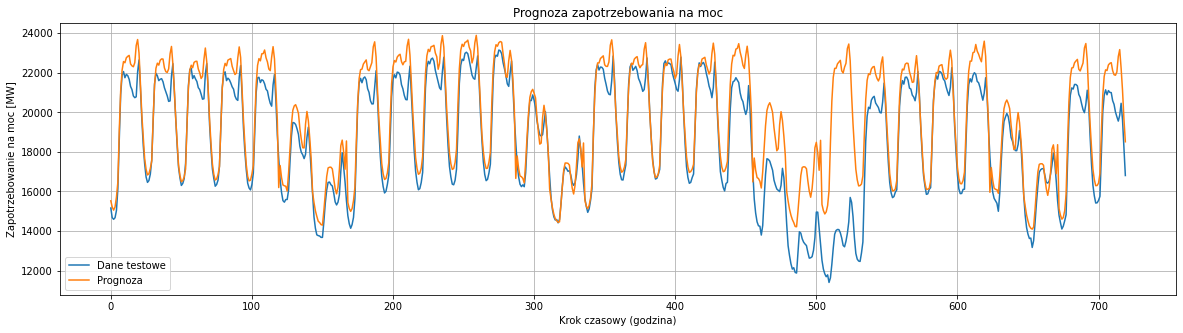

In [36]:
plt.figure(figsize=[20,5])
test_data.iloc[:sample].plot()
combined_forecasted_data.iloc[:sample].plot()
plt.legend(['Dane testowe', 'Prognoza'])
plt.grid()
plt.xlabel('Krok czasowy (godzina)')
plt.ylabel('Zapotrzebowanie na moc [MW]')
plt.title('Prognoza zapotrzebowania na moc')
plt.savefig('Prognoza zapotrzebowania na moc m168s1 z pogoda')